This notebook gives the code to obtain the First Lyapunov Exponent (FLE) of the networks.   
It does NOT give the simulations, only the way to analyze them.  
A code to compute one driven and one self-sustained system is given, on top of the associated files.  

The same analysis was done for different network files, and can be applied immediately with the correct format of data (the average values of the two firing rates and the adaptation at regular time steps of the simulation)

## First, all the imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
from time import time
import pickle
import matplotlib
from copy import deepcopy as dc

%matplotlib notebook

"""
from brian2 import ms
from numpy import median,percentile
from scipy.stats import pearsonr
from seaborn import heatmap 
from scipy.stats import rankdata
from scipy.stats import norm
import scipy.signal  
from mpl_toolkits import mplot3d
import math
from sklearn.neighbors import NearestNeighbors 
import statsmodels.api as sm

"""


'\nfrom brian2 import ms\nfrom numpy import median,percentile\nfrom scipy.stats import pearsonr\nfrom seaborn import heatmap \nfrom scipy.stats import rankdata\nfrom scipy.stats import norm\nimport scipy.signal  \nfrom mpl_toolkits import mplot3d\nimport math\nfrom sklearn.neighbors import NearestNeighbors \nimport statsmodels.api as sm\n\n'

## Then the functions

#### Basic functions

In [2]:
# Basic functions
def dot(v0,v1):
    dim = len(v0)
    dot_prod=0
    for i in range(dim):
        dot_prod+=v0[i]*v1[i]
    return dot_prod

def norm(v):
    dim = len(v)
    res=0
    for i in range(dim):
        res+=v[i]*v[i]
    return np.sqrt(res)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / norm(vector)

def angle_between(v1, v2):
    """ Returns the abs value of the cosinus between two vectors
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.abs(np.clip(dot(v1_u, v2_u), -1.0, 1.0))

def normalize(data):
    """ Take data and normalize all the values between 0 and 1
    """
    return (data-np.min(data))/(np.max(data)-np.min(data))


#### LE functions

In [3]:
def find_close_points(numX,data,delta,dim,Dt):
    """Find the label numY of a point Y such that dist(X,Y)<delta for X, Y in data.
    If there is not at least 10 data points, return -1."""
    
    X=np.array(data[numX])
    Xmax=[]
    for i in range(dim):
        Xmax.append([X[i]-delta,X[i]+delta])
    close_points=[]
    flag=0
    i=0
    data_dt=data[:-Dt-1]
    
    while i<len(data_dt):
        val=data_dt[i]
        i+=1
        flag2=0
        for j in range(dim):
            if val[j]<Xmax[j][0] or val[j]>Xmax[j][1]:
                flag2=1
                break
        if flag2==1:
            continue
        elif norm(X-val)<delta:
                if i-1 not in range(numX-100,numX+100):
                    close_points.append(i-1)
                    flag+=1


    if flag>1:
        return close_points
    else:
        return -1
    

def find_points_ortho(numX,numY,data,delta,Dt,dim):
    """We have numX and numY, index of points X and Y that are respectively the 
    fiducial point and a point that evolved and is aligned with the FLE vector.
    First, we want to find a point aligned with the vector (X,Y) but closer to X,
    that we will call Y1. This will help to keep finding local values of the FLE.
    Then, we want to find Y2, a point close to X and such that (X,Y2) is orthogonal
    to (X,Y1), ensuring it does not follow the FLE direction. """
    points=find_close_points(numX,data,delta,dim,Dt)
    angle1=0.95#min cos(angle) we allow
    flag1=0
    new_num1=-1
    X=np.array(data[numX])
    Y=np.array(data[numY])
    v1=Y-X
    delta_temp=delta
    while points==-1:
        points=find_close_points(numX,data,delta_temp,dim,Dt)
        delta_temp+=0.5*delta
    delta_temp1=delta_temp
    points1=dc(points)    
    #First, let's select the vector that aligns with the FLE
    while flag1==0:
        for num in points1:
            v2=data[num]-X
            ang=angle_between(v1,v2)#we want something as close to 1 as possible (colinear)
            if ang>angle1:
                flag1=1
                angle1=ang
                new_num1=num
        if flag1==0:
            delta_temp1+=0.5*delta
            points1_2=find_close_points(numX,data,delta_temp1,dim,Dt)
            points1=[val for val in points1_2 if val not in points1]
   
    return new_num1



def LE_algo(Xs,t0,Dt,dt,delta,eps0,time_max):
    """Standard algo for lyapunov spectrum with Dt a time between each 
    LE evaluation, dt a time step, eps a small perturbation, eps0 a tolerance 
    to end the algo, t0 the initial value x(t0) and u0 a set of orthonormal 
    vectors at time T0. Here we use time series instead of the flow. The main difference
    is therefor that we use closer neighbors instead of perturbations."""
  
    dim=np.shape(Xs)[1]
    
    l_pert1=[0] #initialize the LE perturbated
    
    #initialize the first point that will align with the FLE
    ty0=-1
    delta_temp=delta
    while ty0==-1:
        ty0=find_close_points(t0,Xs[:-Dt-1],delta_temp,dim,Dt)
        delta_temp+=0.5*delta
    ty0=np.random.permutation(ty0[:-1])[-1]
    
    for t in range(time_max): #I prefer long time to while loops
        #Evolution of the trajectory with a step dt until Dt
        
        x0=np.array(Xs[t0])
        
       
        #"Perturbation" like (finding points close and colinear to the vectors (x1,y1), 
        #and another one orthogonal to it)
        x_pert1_nums=find_points_ortho(t0,ty0,Xs,delta,Dt,dim)
        dists=norm(Xs[x_pert1_nums]-x0)
        #2D distances between original points and "perturbation"
        
        #"Evolve perturbation"
        Dt_temp=0
        for i in range(Dt):
            Dt_temp+=1
            if (x_pert1_nums+Dt_temp)>=len(Xs)-Dt:
                Dt_temp-=1
                break

                
        t1=t0+Dt_temp
        x1=Xs[t1]

        x_pert1_nums=x_pert1_nums+Dt_temp#2D index
        x_pert1=Xs[x_pert1_nums] #2 3D-coordinates 

        #Compute difference
        w1=x_pert1-x1

        
        #Find growth
        v_norms1=norm(w1)#gives the norm of the first vector and the norm of the projection
        #Compute the LS
        l_pert1.append(np.log(v_norms1/dists)/(Dt_temp*dt))
        #Check if we can stop
        if np.abs(np.mean(l_pert1[:-1])-np.mean(l_pert1[:-2]))<eps0:
            return t+1,l_pert1
        else:
            t0=t1
            ty0=x_pert1_nums
    return -1,l_pert1

## Analysis

### First with a driven network

#### Import the simulation files

In [6]:
file_res='Simulation_Adex_1'
with open(file_res, "rb") as f:
    Res=pickle.load(f)
[FR_input,W]=Res[0] 

FR_1=normalize(FR_input[0][11000:-10000])
FR_2=normalize(FR_input[1][11000:-10000])
W=normalize(W[11000:-10000])

Xs1=np.transpose([FR_1,FR_2,W])


file_res=root+'Simulation_Adex_2'
with open(file_res, "rb") as f:
    Res=pickle.load(f)
[FR_input2,W2]=Res[0] 

FR_1_2=normalize(FR_input2[0][11000:-10000])
FR_2_2=normalize(FR_input2[1][11000:-10000])
W2=normalize(W2[11000:-10000])

Xs2=np.transpose([FR_1_2,FR_2_2,W2])


#### Apply the algorithm up to a given precision or a given number of loops

WARNING    /home/jboute/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 [py.warnings]
WARNING    /home/jboute/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]


It took 727.6612722873688s to make 1711 loops and attain a precision of 1e-07
It took 516.3211278915405s to make 1172 loops and attain a precision of 1e-07


<IPython.core.display.Javascript object>


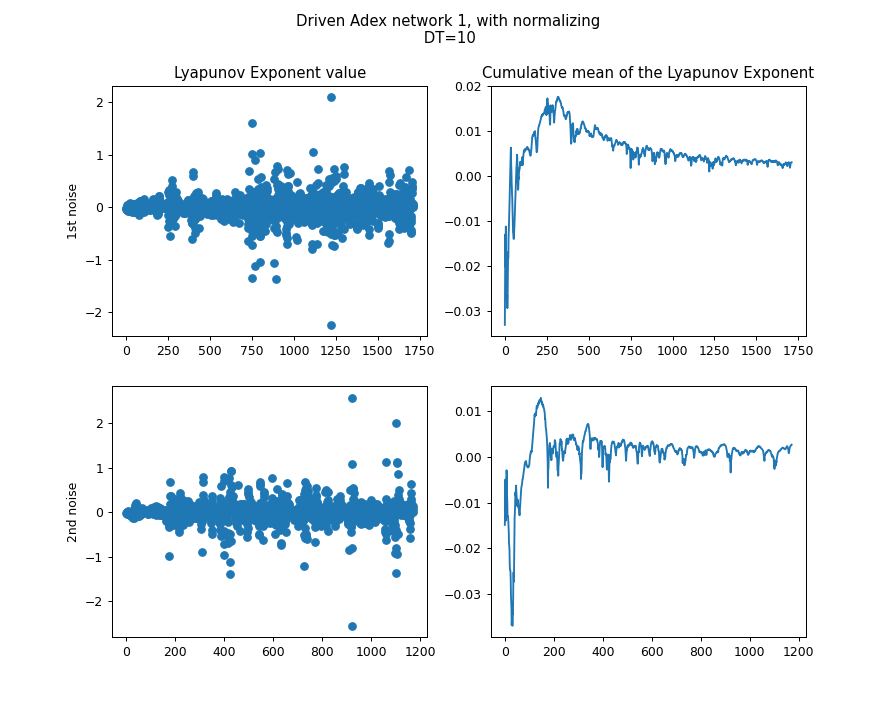

LE_1=0.0029606887557966583	LE_2=0.002682045144471961


In [57]:
t0=0
DT=0.1#ms
N=10#number of steps
delta=0.1
eps0=1E-7
time_max=2000

tic=time()
res1=LE_algo(Xs1,t0,N,DT,delta,eps0,time_max)
tac=time()
if res1[0]==-1:
    print('It took {}s to make {} loops, but the precision of {} was not attained'.format(tac-tic,time_max,eps0))
else:
    print('It took {}s to make {} loops and attain a precision of {}'.format(tac-tic,res1[0],eps0))

    
tic=time()
res2=LE_algo(Xs2,t0,N,DT,delta,eps0,time_max)
tac=time()
if res2[0]==-1:
    print('It took {}s to make {} loops, but the precision of {} was not attained'.format(tac-tic,time_max,eps0))
else:
    print('It took {}s to make {} loops and attain a precision of {}'.format(tac-tic,res2[0],eps0))


lyaps1=res1[1][1:]
lyap_means1=np.cumsum(lyaps1)/np.arange(1,len(lyaps1)+1)

lyaps2=res2[1][1:]
lyap_means2=np.cumsum(lyaps2)/np.arange(1,len(lyaps2)+1)


fig,ax=plt.subplots(2,2,figsize=[10,8])
ax[0][0].plot(lyaps1,'o')
ax[0][1].plot(lyap_means1)
ax[1][0].plot(lyaps2,'o')
ax[1][1].plot(lyap_means2)
ax[0][0].set_title('Lyapunov Exponent value')
ax[0][1].set_title('Cumulative mean of the Lyapunov Exponent')
ax[0][0].set_ylabel('1st noise')
ax[1][0].set_ylabel('2nd noise')

fig.suptitle('Driven Adex network 1, with normalizing\n DT={}'.format(N))
plt.show();

print('LE_1={}\tLE_2={}'.format(lyap_means1[-1],lyap_means2[-1]))

#### Apply it again with a different number of steps between two loops

WARNING    /home/jboute/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 [py.warnings]
WARNING    /home/jboute/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]


It took 334.8806257247925s to make 806 loops and attain a precision of 1e-07
It took 754.6947190761566s to make 1835 loops and attain a precision of 1e-07


<IPython.core.display.Javascript object>


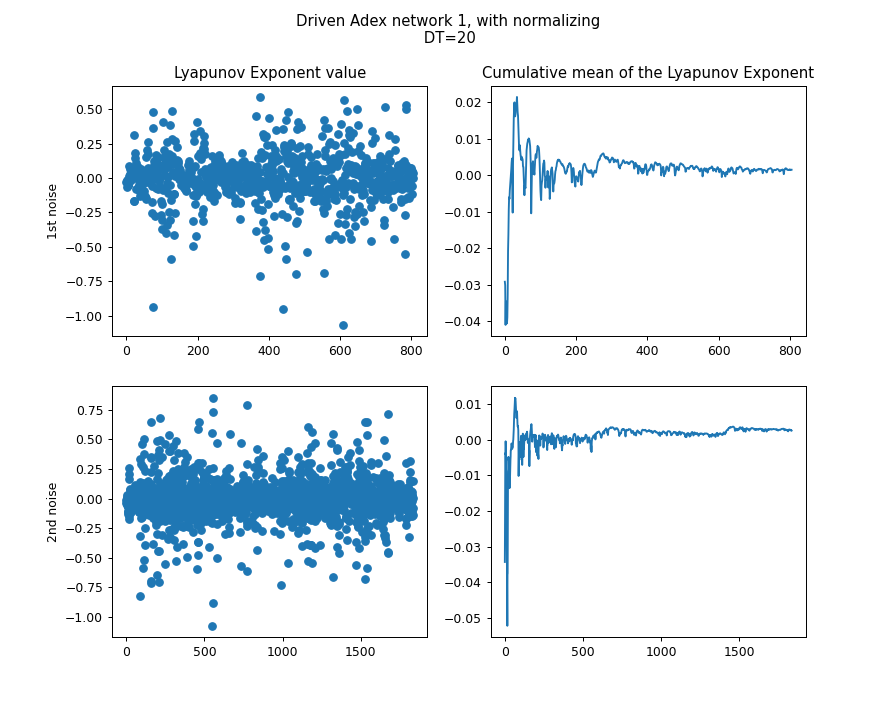

LE_1=0.0015344928373305943	LE_2=0.0025600044402910335


In [58]:
t0=0
DT=0.1#ms
N=20#number of steps
delta=0.1
eps0=1E-7
time_max=2000

tic=time()
res1=LE_algo(Xs1,t0,N,DT,delta,eps0,time_max)
tac=time()
if res1[0]==-1:
    print('It took {}s to make {} loops, but the precision of {} was not attained'.format(tac-tic,time_max,eps0))
else:
    print('It took {}s to make {} loops and attain a precision of {}'.format(tac-tic,res1[0],eps0))

    
tic=time()
res2=LE_algo(Xs2,t0,N,DT,delta,eps0,time_max)
tac=time()
if res2[0]==-1:
    print('It took {}s to make {} loops, but the precision of {} was not attained'.format(tac-tic,time_max,eps0))
else:
    print('It took {}s to make {} loops and attain a precision of {}'.format(tac-tic,res2[0],eps0))


lyaps1=res1[1][1:]
lyap_means1=np.cumsum(lyaps1)/np.arange(1,len(lyaps1)+1)

lyaps2=res2[1][1:]
lyap_means2=np.cumsum(lyaps2)/np.arange(1,len(lyaps2)+1)


fig,ax=plt.subplots(2,2,figsize=[10,8])
ax[0][0].plot(lyaps1,'o')
ax[0][1].plot(lyap_means1)
ax[1][0].plot(lyaps2,'o')
ax[1][1].plot(lyap_means2)
ax[0][0].set_title('Lyapunov Exponent value')
ax[0][1].set_title('Cumulative mean of the Lyapunov Exponent')
ax[0][0].set_ylabel('1st noise')
ax[1][0].set_ylabel('2nd noise')

fig.suptitle('Driven Adex network 1, with normalizing\n DT={}'.format(N))
plt.show();

print('LE_1={}\tLE_2={}'.format(lyap_means1[-1],lyap_means2[-1]))

The same thing can be done with the second driven file

### Same with the self-sustained network

In [4]:
file_res='Simulation_Adex_sustained_1'
with open(file_res, "rb") as f:
    Res=pickle.load(f)
[FR_input,W]=Res[0] 

FR_1=normalize(FR_input[0][11000:-10000])
FR_2=normalize(FR_input[1][11000:-10000])
W=normalize(W[11000:-10000])

Xs1=np.transpose([FR_1,FR_2,W])

/home/jboute/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jboute/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


It took 699.1983437538147s to make 1975 loops and attain a precision of 1e-07


<IPython.core.display.Javascript object>


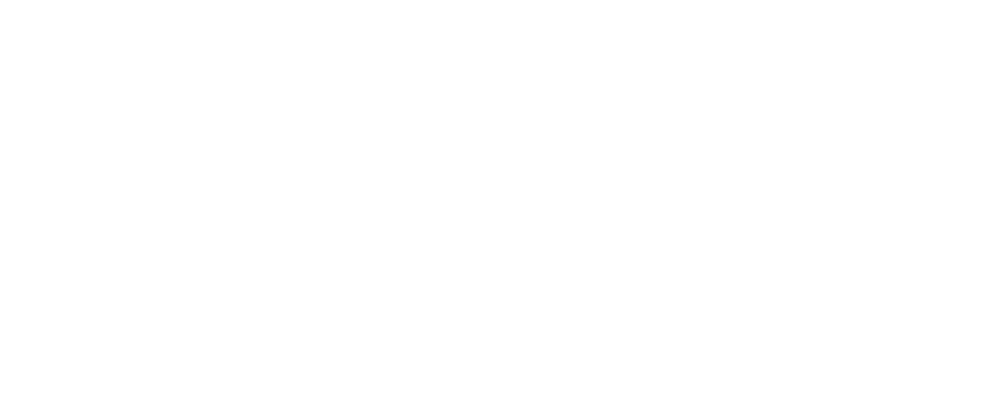

LE_1=0.04195555014480161


In [10]:
t0=0
DT=0.1#ms
N=10#number of steps
delta=0.1
eps0=1E-7
time_max=2000

tic=time()
res1=LE_algo(Xs1,t0,N,DT,delta,eps0,time_max)
tac=time()
if res1[0]==-1:
    print('It took {}s to make {} loops, but the precision of {} was not attained'.format(tac-tic,time_max,eps0))
else:
    print('It took {}s to make {} loops and attain a precision of {}'.format(tac-tic,res1[0],eps0))

    


lyaps1=res1[1][1:]
lyap_means1=np.cumsum(lyaps1)/np.arange(1,len(lyaps1)+1)


fig,ax=plt.subplots(1,2,figsize=[10,4])
ax[0].plot(lyaps1,'o')
ax[1].plot(lyap_means1)
ax[0].set_title('Lyapunov Exponent value')
ax[1].set_title('Cumulative mean of the Lyapunov Exponent')
ax[0].set_ylabel('1st noise')

fig.suptitle('Driven Adex network 1, with normalizing\n DT={}'.format(N))
plt.show();

print('LE_1={}'.format(lyap_means1[-1]))
